<a href="https://colab.research.google.com/github/atheendre130505/gans_monet/blob/main/CUT_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

gan_getting_started_path = kagglehub.competition_download('gan-getting-started')

print('Data source import complete.')


100%|██████████| 367M/367M [00:18<00:00, 20.5MB/s]

Extracting files...


Data source import complete.


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
# Set device to GPU if available, otherwise CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Path to the dataset on Kaggle - UPDATED TO USE THE DOWNLOADED PATH
DATA_PATH = gan_getting_started_path  # Use the path returned by kagglehub.competition_download
MONET_PATH = os.path.join(DATA_PATH, "monet_jpg")
PHOTO_PATH = os.path.join(DATA_PATH, "photo_jpg")

# Image and training settings
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1 # For CUT, a batch size of 1 is standard

print(f"Using device: {DEVICE}")
print(f"Monet images found: {len(os.listdir(MONET_PATH))}")
print(f"Photo images found: {len(os.listdir(PHOTO_PATH))}")

Using device: cuda
Monet images found: 300
Photo images found: 7038


In [18]:
class ImageDataset(Dataset):
    """
    A custom dataset class to load images from a directory.
    """
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Use glob to find all jpg files
        self.image_files = glob.glob(os.path.join(self.root_dir, "*.jpg"))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        img_path = self.image_files[idx]
        # Open the image using PIL
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image

In [19]:
# --- Transformations ---
# This is our data augmentation and preprocessing pipeline
# The values for mean and std are (0.5, 0.5, 0.5) to normalize images to [-1, 1]
transforms = T.Compose([
    T.Resize(int(IMG_HEIGHT * 1.12), T.InterpolationMode.BICUBIC),
    T.RandomCrop((IMG_HEIGHT, IMG_WIDTH)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- Create Datasets and DataLoaders ---
# Instantiate the datasets
monet_dataset = ImageDataset(root_dir=MONET_PATH, transform=transforms)
photo_dataset = ImageDataset(root_dir=PHOTO_PATH, transform=transforms)

# Create the DataLoaders
monet_loader = DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
photo_loader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Monet dataset size: {len(monet_dataset)}")
print(f"Photo dataset size: {len(photo_dataset)}")

Monet dataset size: 300
Photo dataset size: 7038


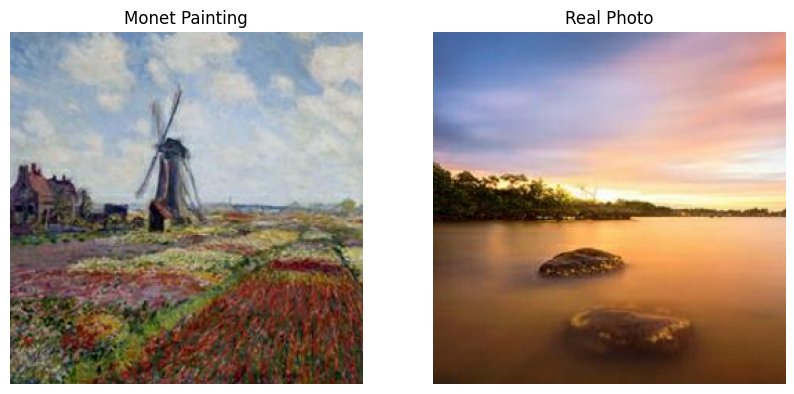

In [20]:
def denormalize_img(img_tensor):
    """Denormalizes a tensor image from [-1, 1] to [0, 1] for visualization."""
    return img_tensor * 0.5 + 0.5

# Get one example from each loader
example_monet = next(iter(monet_loader))
example_photo = next(iter(photo_loader))

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display Monet painting
# We use permute(1, 2, 0) to change from (C, H, W) to (H, W, C) for matplotlib
ax[0].imshow(denormalize_img(example_monet[0]).permute(1, 2, 0))
ax[0].set_title("Monet Painting")
ax[0].axis("off")

# Display Photo
ax[1].imshow(denormalize_img(example_photo[0]).permute(1, 2, 0))
ax[1].set_title("Real Photo")
ax[1].axis("off")

plt.show()

In [21]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    A single residual block for the Generator.
    """
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        # The convolutional block
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Padding to keep size constant
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        # The output of the block is added to the input (the "residual" connection)
        return x + self.block(x)

In [22]:
class Discriminator(nn.Module):
    """
    The PatchGAN discriminator.
    """
    def __init__(self, input_nc=3):
        super().__init__()

        # A series of Conv2d -> InstanceNorm2d -> LeakyReLU blocks
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_nc, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1) # Final output layer
        )

    def forward(self, img):
        return self.model(img)

In [23]:
class PatchNCEHead(nn.Module):
    """
    The projection head for the PatchNCE loss.
    This is a simple 2-layer MLP.
    """
    def __init__(self, in_c, proj_c=256):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_c, proj_c, 1),
            nn.ReLU(),
            nn.Conv2d(proj_c, proj_c, 1),
        )

    def forward(self, x):
        return self.proj(x)

In [24]:
import torch.nn.functional as F

# --- Weight Initialization ---
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution with mean=0, std=0.02.
    """
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

In [35]:
import torch.nn.functional as F

# --- GAN Loss (using Mean Squared Error) ---
# This measures how well the generator can fool the discriminator.
gan_loss_fn = nn.MSELoss()

# --- Identity Loss (using L1 Loss) ---
# This encourages the generator to not change images that are already in the target domain.
# For example, G(monet_image) should be very close to monet_image.
identity_loss_fn = nn.L1Loss()

class PatchNCELoss(nn.Module):
    """
    The main contrastive loss function for CUT.
    It calculates the cross-entropy loss between positive and negative patches.
    """
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        # Use CrossEntropyLoss with logits, as we'll compute similarities (logits) manually
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction="none")

    def forward(self, feat_q, feat_k):
        # Normalize the features to be on the unit sphere
        feat_q = F.normalize(feat_q, p=2, dim=1)
        feat_k = F.normalize(feat_k, p=2, dim=1)

        # Calculate the similarity between the query and all keys (positive and negative)
        # feat_k.transpose(2, 3) makes it (B, C, W, H) to prepare for matrix multiplication
        # The result `l_all` will have shape (B, N, N) where N is num_patches
        l_all = torch.matmul(feat_q.transpose(1,3), feat_k.transpose(1,3).transpose(2,3))

        # The diagonal elements are the similarities between corresponding patches (positives)
        # Use reshape instead of view as suggested by the error
        l_pos = torch.diagonal(l_all, dim1=-2, dim2=-1).reshape(l_all.shape[0], -1, 1)

        # The off-diagonal elements are the similarities with other patches (negatives)
        # We create a mask to select only the off-diagonal elements
        mask = ~torch.eye(l_all.shape[-1], device=l_all.device, dtype=torch.bool).unsqueeze(0)
        l_neg = l_all[mask].view(l_all.shape[0], -1, l_all.shape[-1] - 1) # Keep view here as it should be fine after masking

        # Create the final logits tensor: [positive_similarity, negative_similarity_1, negative_similarity_2, ...]
        out = torch.cat((l_pos, l_neg), dim=2) / self.temperature

        # The target for cross-entropy is always the first element (the positive one)
        # So we create a tensor of zeros.
        targets = torch.zeros(out.size(0), out.size(1), dtype=torch.long, device=out.device)

        # Calculate the loss and return the mean over all patches and batches
        loss = self.cross_entropy_loss(out.transpose(1,2), targets)
        return loss.mean()

# Instantiate the PatchNCE loss
patch_nce_loss_fn = PatchNCELoss().to(DEVICE)

In [26]:
from itertools import chain

# --- Hyperparameters ---
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999

# --- Create Optimizers ---
# The generator's optimizer updates both the generator and the PatchNCE head


Optimizers created.


In [33]:
class Generator(nn.Module):
    """
    The ResNet-based generator, now modified to return intermediate features for PatchNCE loss.
    """
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=9):
        super(Generator, self).__init__()
        self.n_residual_blocks = n_residual_blocks # Store as instance variable

        # --- Initial Convolution Block ---
        self.initial_block = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # --- Downsampling ---
        in_features = 64
        self.downsampling = nn.ModuleList()
        for i in range(2):
            out_features = in_features * 2
            self.downsampling.append(nn.Sequential(
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ))
            in_features = out_features

        # --- Residual Blocks ---
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(in_features) for _ in range(self.n_residual_blocks)] # Use self.n_residual_blocks
        )

        # --- Upsampling ---
        self.upsampling = nn.ModuleList()
        for i in range(2):
            out_features = in_features // 2
            self.upsampling.append(nn.Sequential(
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ))
            in_features = out_features


        # --- Output Layer ---
        self.output_block = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        )

    def forward(self, x, extract_features=False):
        # --- Encoder Path ---
        features = []
        x = self.initial_block(x)
        if extract_features:
            features.append(x)

        for layer in self.downsampling:
            x = layer(x)
            if extract_features:
                features.append(x)

        # Process residual blocks and collect features
        if extract_features:
            num_features_from_residual = 5 - len(features) # We want a total of 5 features for NCE
            # Use self.n_residual_blocks here
            residual_feature_indices = [int(i * (self.n_residual_blocks - 1) / (num_features_from_residual - 1)) for i in range(num_features_from_residual)] if num_features_from_residual > 1 else [0]

            residual_output = x
            for i, layer in enumerate(self.residual_blocks):
                residual_output = layer(residual_output)
                if i in residual_feature_indices:
                    features.append(residual_output)
            x = residual_output # Use the output of the residual blocks for the decoder
        else:
             x = self.residual_blocks(x)


        if extract_features:
            return features


        # --- Decoder Path ---
        for layer in self.upsampling:
            x = layer(x)

        output = self.output_block(x)
        return output


# --- Instantiate Models ---
# Generator for Photo -> Monet
gen_photo_to_monet = Generator().to(DEVICE)
# Discriminator for Monet domain
disc_monet = Discriminator().to(DEVICE)

# Determine the channel sizes of the features extracted by the generator
# Create a dummy input to get the feature shapes
dummy_input = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(DEVICE)
with torch.no_grad(): # No need to calculate gradients for this
    dummy_features = gen_photo_to_monet(dummy_input, extract_features=True)

# Create a list of PatchNCE Heads, one for each feature map resolution
patch_nce_heads = nn.ModuleList([PatchNCEHead(in_c=f.shape[1]).to(DEVICE) for f in dummy_features])


# Apply the weight initialization
gen_photo_to_monet.apply(weights_init_normal)
disc_monet.apply(weights_init_normal)
# Apply weight initialization to each head in the list
for head in patch_nce_heads:
    head.apply(weights_init_normal)


print("Models initialized and moved to device.")

# Re-chain the parameters for the optimizer
# The generator optimizer now includes parameters from all PatchNCE heads
optimizer_G = torch.optim.Adam(
    chain(gen_photo_to_monet.parameters(), *[head.parameters() for head in patch_nce_heads]),
    lr=LR,
    betas=(BETA1, BETA2)
)

optimizer_D = torch.optim.Adam(
    disc_monet.parameters(),
    lr=LR,
    betas=(BETA1, BETA2)
)

Models initialized and moved to device.


In [ ]:
from tqdm.notebook import tqdm
import itertools
import os
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils


# --- Hyperparameters for the losses ---
lambda_GAN = 1.0
lambda_NCE = 1.0
lambda_ID = 0.5 # A lower weight for the identity loss is common
num_epochs = 10 # Set the number of epochs to train for

# Define the directory for saving checkpoints and generated images
checkpoint_dir = "./training_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

output_images_dir = "./generated_images"
os.makedirs(output_images_dir, exist_ok=True)


# --- Load Model Weights and Optimizers (if resuming training) ---
# Define the paths to the saved checkpoints
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    gen_photo_to_monet.load_state_dict(checkpoint['gen_state_dict'])
    disc_monet.load_state_dict(checkpoint['disc_state_dict'])
    patch_nce_heads.load_state_dict(checkpoint['nce_heads_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("No checkpoint found, starting training from scratch.")


# --- Main Training Loop ---
for epoch in range(start_epoch, num_epochs):
    # Set models to training mode
    gen_photo_to_monet.train()
    disc_monet.train()
    patch_nce_heads.train()


    # Use tqdm for a nice progress bar
    progress_bar = tqdm(enumerate(photo_loader), total=len(photo_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    # We need an iterator for monet_loader to grab Monet images on demand
    monet_iterator = iter(monet_loader)

    for i, real_photo in progress_bar:
        real_photo = real_photo.to(DEVICE)

        # Get a corresponding real Monet painting. Use itertools.cycle if one dataset is smaller.
        try:
            real_monet = next(monet_iterator).to(DEVICE)
        except StopIteration:
            # Reset iterator if we've gone through all Monet images
            monet_iterator = iter(monet_loader)
            real_monet = next(monet_iterator).to(DEVICE)


        # ---------------------------------
        #  Train Generator and Heads
        # ---------------------------------
        optimizer_G.zero_grad()

        # Generate a fake Monet painting from a real photo
        fake_monet = gen_photo_to_monet(real_photo)

        # --- Adversarial (GAN) Loss for Generator ---
        # The generator wants the discriminator to think the fake Monet is real
        pred_fake = disc_monet(fake_monet)
        target_real = torch.ones_like(pred_fake) # Target is "real" (1s)
        loss_G_GAN = gan_loss_fn(pred_fake, target_real)

        # --- Identity Loss ---
        # The generator should not change an image that's already in the target domain
        same_monet = gen_photo_to_monet(real_monet)
        loss_identity = identity_loss_fn(same_monet, real_monet)

        # --- PatchNCE Loss ---
        # Extract features from both the real photo and the fake monet
        feat_real_photo = gen_photo_to_monet(real_photo, extract_features=True)
        feat_fake_monet = gen_photo_to_monet(fake_monet, extract_features=True)

        # Pass the extracted features through the corresponding projection heads
        total_nce_loss = 0.0
        # Iterate through the extracted features and the corresponding heads
        for j in range(len(feat_fake_monet)):
            proj_fake_monet = patch_nce_heads[j](feat_fake_monet[j])
            proj_real_photo = patch_nce_heads[j](feat_real_photo[j])
            total_nce_loss += patch_nce_loss_fn(proj_fake_monet, proj_real_photo)

        loss_NCE = total_nce_loss / len(feat_fake_monet)

        # --- Total Generator Loss ---
        # Combine all losses with their weights
        loss_G = (loss_G_GAN * lambda_GAN) + (loss_NCE * lambda_NCE) + (loss_identity * lambda_ID)

        loss_G.backward()
        optimizer_G.step()


        # ---------------------------------
        #  Train Discriminator
        # ---------------------------------
        optimizer_D.zero_grad()

        # Loss for real images
        pred_real = disc_monet(real_monet)
        target_real = torch.ones_like(pred_real)
        loss_D_real = gan_loss_fn(pred_real, target_real)

        # Loss for fake images
        # Use .detach() to stop gradients from flowing back to the generator
        pred_fake = disc_monet(fake_monet.detach())
        target_fake = torch.zeros_like(pred_fake) # Target is "fake" (0s)
        loss_D_fake = gan_loss_fn(pred_fake, target_fake)

        # Total discriminator loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5

        loss_D.backward()
        optimizer_D.step()

        # Update progress bar description with current losses
        progress_bar.set_postfix({
            "G_loss": loss_G.item(), "D_loss": loss_D.item(),
            "G_GAN": loss_G_GAN.item(), "NCE": loss_NCE.item(), "ID": loss_identity.item()
        })

    # --- Save Checkpoints after each epoch ---
    # Save the latest checkpoint
    torch.save({
        'epoch': epoch + 1,
        'gen_state_dict': gen_photo_to_monet.state_dict(),
        'disc_state_dict': disc_monet.state_dict(),
        'nce_heads_state_dict': patch_nce_heads.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, checkpoint_path)
    print(f"\nCheckpoint saved to {checkpoint_path}")


    # --- Visualization and Evaluation after each epoch ---
    print("Generating sample images for visualization...")
    # Set models to evaluation mode for visualization
    gen_photo_to_monet.eval()

    # Get a batch of real photos for generating fake images
    with torch.no_grad(): # Disable gradient calculations
        sample_real_photos = next(iter(photo_loader)).to(DEVICE)
        fake_monet_samples = gen_photo_to_monet(sample_real_photos)

    # Denormalize the images for display and saving
    fake_monet_samples = denormalize_img(fake_monet_samples).cpu()
    sample_real_photos = denormalize_img(sample_real_photos).cpu()

    # Create a grid of images
    img_grid = vutils.make_grid(torch.cat((sample_real_photos, fake_monet_samples), dim=0), nrow=sample_real_photos.size(0), padding=2, normalize=True)

    # Save the image grid
    vutils.save_image(img_grid, os.path.join(output_images_dir, f"epoch_{epoch+1}_generated_samples.png"))

    # Display the image grid
    plt.figure(figsize=(sample_real_photos.size(0) * 2, 4))
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} - Real Photos vs. Generated Monet")
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    plt.show()

    # Simple Evaluation (Optional) - You could add more complex metrics here
    # For simplicity, we'll just display the losses from the last batch of the epoch
    print(f"Epoch {epoch+1} Summary - G_loss: {loss_G.item():.4f}, D_loss: {loss_D.item():.4f}")

No checkpoint found, starting training from scratch.


Epoch 1/10:   0%|          | 0/7038 [00:00<?, ?it/s]